# Text to Point Cloud Diffusion

In our work we explored using two different diffusion models in order to go from text-prompt to point cloud. 

    1. Finetuned GLIDE
    2. Stable Diffusion with training free layout control 
    
In the this notebook we demonstrate the differences between using both diffusion models in the text-to-image regime, before applying the pointcloud diffusion model.

In [1]:
# Standard imports
import seaborn as sns
import matplotlib.pyplot as plt
import imageio, importlib
from PIL import Image
import numpy as np
import nopdb
import math
import torch
from tqdm.auto import tqdm
from hydra import compose, initialize
import json
import os
import sys
from transformers import CLIPTextModel, CLIPTokenizer
from diffusers import AutoencoderKL, LMSDiscreteScheduler
from omegaconf import OmegaConf

# Detect local paths
local_path = !pwd
local_path = local_path[0][:-5]
sys.path.append(local_path + 'src/')

# Import from modules
from point_e.diffusion.configs import DIFFUSION_CONFIGS, diffusion_from_config
from point_e.diffusion.sampler import PointCloudSampler
from point_e.models.download import load_checkpoint
from point_e.models.configs import MODEL_CONFIGS, model_from_config
from point_e.util.plotting import plot_point_cloud
from point_e.util.plotting import plot_attention_cloud

from layout_guidance.inference import inference
from layout_guidance.utils import view_images
from layout_guidance.utils import setup_logger
from layout_guidance.my_model import unet_2d_condition

## Finetuning Glide

Initially we look at the result of finetuning glide using the prompt
    
    'A simple chair beside a table in a white background.'


As can be observed in the final output of the pointcloud, Point-E based on finetuned GLIDE is incapable of producing a satisfactory pointcloud. It misinterprets the notion of a white background as a request to have the chair white, and it fails to produce a table. 

### Import point-cloud-diffusion models from point-e

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M-textvec'
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [3]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 0.0],
    model_kwargs_key_filter=('texts', ''), # Do not condition the upsampler at all
)

### Example ouput of  text-to-PointCloud diffusion with glide

In [4]:
# Set a prompt to condition on.
prompt = 'A simple chair beside a table in a white background.'

# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(texts=[prompt]))):
    samples = x

0it [00:00, ?it/s]

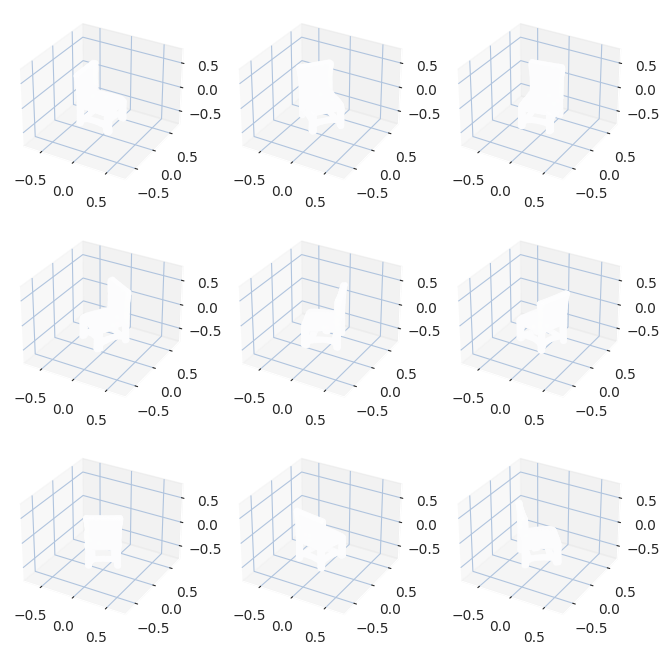

In [5]:
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))

## Stable diffusion with training free layout control

Subsequently, we look at the result of using training-free layoutcontrol with a stable diffusion backbone to generate an image using the same prompt.
    
    'A simple chair beside a table in a white background.'

We refer to the notbook *Demo_StableDiffusion* for the generation of the image, here we simply load it from storage.

In [6]:
# Compose configuration file
initialize(config_path="conf")
cfg = compose(config_name="base_config")

# Build model
with open(cfg.general.unet_config) as f:
    unet_config = json.load(f)
unet = unet_2d_condition.UNet2DConditionModel(**unet_config).from_pretrained(cfg.general.model_path, subfolder="unet")
tokenizer = CLIPTokenizer.from_pretrained(cfg.general.model_path, subfolder="tokenizer")
text_encoder = CLIPTextModel.from_pretrained(cfg.general.model_path, subfolder="text_encoder")
vae = AutoencoderKL.from_pretrained(cfg.general.model_path, subfolder="vae")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

unet.to(device)
text_encoder.to(device)
vae.to(device)

/scratch/ipykernel_16146/567382086.py:2: UserWarning: 
The version_base parameter is not specified.
Please specify a compatability version level, or None.
Will assume defaults for version 1.1
  initialize(config_path="conf")


AutoencoderKL(
  (encoder): Encoder(
    (conv_in): Conv2d(3, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (down_blocks): ModuleList(
      (0): DownEncoderBlock2D(
        (resnets): ModuleList(
          (0): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (nonlinearity): SiLU()
          )
          (1): ResnetBlock2D(
            (norm1): GroupNorm(32, 128, eps=1e-06, affine=True)
            (conv1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 128, eps=1e-06, affine=True)
            (dropout): Dropout(p=0.0, inplace=False)
            (conv2): Conv2d(128, 128, kernel_size=(3,

100%|██████████| 51/51 [00:22<00:00,  2.30it/s]


Prompt:  A simple chair beside a table in a white background.


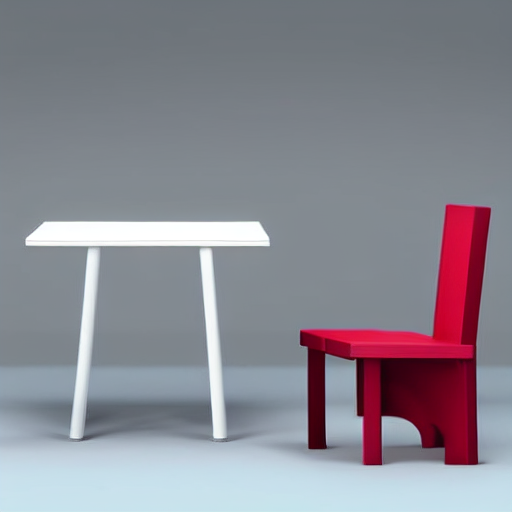

In [7]:
# Prompt
examples = {"prompt": "A simple chair beside a table in a white background.",
            "phrases": "table; chair",
            "bboxes": [[[0.1, 0.4, 0.5, 0.8]], [[0.75, 0.4, 0.95, 0.8]]],
            'save_path': cfg.general.save_path
            }

# Prepare the save path
if not os.path.exists(cfg.general.save_path):
    os.makedirs(cfg.general.save_path)
logger = setup_logger(cfg.general.save_path, __name__)

logger.info(cfg)
# Save cfg
logger.info("save config to {}".format(os.path.join(cfg.general.save_path, 'config.yaml')))
OmegaConf.save(cfg, os.path.join(cfg.general.save_path, 'config.yaml'))


# Inference
pil_images = inference(device, unet, vae, tokenizer, text_encoder, examples['prompt'], examples['bboxes'], examples['phrases'], cfg, logger)
print('Prompt: ', examples["prompt"])
image = view_images(np.stack(pil_images, axis=0), cfg.general.save_path)

# Save example images
for index, pil_image in enumerate(pil_images):
    image_path = os.path.join(cfg.general.save_path, 'example_{}.png'.format(index))
    logger.info('save example image to {}'.format(image_path))

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('creating base model...')
base_name = 'base40M' # use base300M or base1B for better results
base_model = model_from_config(MODEL_CONFIGS[base_name], device)
base_model.eval()
base_diffusion = diffusion_from_config(DIFFUSION_CONFIGS[base_name])

print('creating upsample model...')
upsampler_model = model_from_config(MODEL_CONFIGS['upsample'], device)
upsampler_model.eval()
upsampler_diffusion = diffusion_from_config(DIFFUSION_CONFIGS['upsample'])

print('downloading base checkpoint...')
base_model.load_state_dict(load_checkpoint(base_name, device))

print('downloading upsampler checkpoint...')
upsampler_model.load_state_dict(load_checkpoint('upsample', device))

creating base model...
creating upsample model...
downloading base checkpoint...
downloading upsampler checkpoint...


<All keys matched successfully>

In [9]:
sampler = PointCloudSampler(
    device=device,
    models=[base_model, upsampler_model],
    diffusions=[base_diffusion, upsampler_diffusion],
    num_points=[1024, 4096 - 1024],
    aux_channels=['R', 'G', 'B'],
    guidance_scale=[3.0, 3.0],
)

0it [00:00, ?it/s]

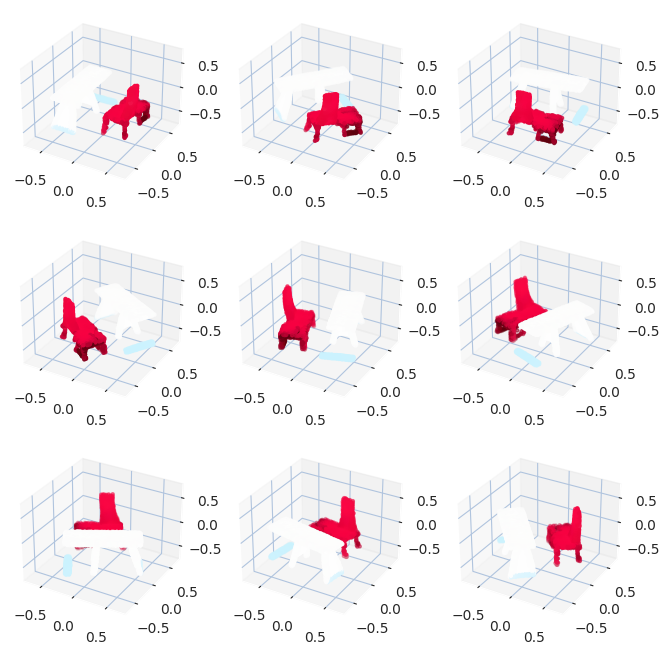

In [10]:
# Produce a sample from the model.
samples = None
for x in tqdm(sampler.sample_batch_progressive(batch_size=1, model_kwargs=dict(images=[image]))):
    samples = x
    
pc = sampler.output_to_point_clouds(samples)[0]
fig = plot_point_cloud(pc, grid_size=3, fixed_bounds=((-0.75, -0.75, -0.75),(0.75, 0.75, 0.75)))